# Experiment 033

In this experiment, we tweak the generator architecture, still training with reconstruction loss.

In [1]:
import os
from pathlib import Path
import shutil
import datetime

import torch
from torch import nn
from torch.utils.data import DataLoader
import torch.nn.functional as F
from torch.utils.data import Dataset
import numpy as np
from torch.utils.tensorboard import SummaryWriter
import matplotlib.pyplot as plt


import models
import metrics
from recording import FileBasedDatabaseWithEvents
from engines import EVENT_NAMES

In [2]:
NUM_CELL_TYPES = 8
NUM_EVENT_TYPES = 5

class RecordingDataset(Dataset):
    def __init__(self, path: str):
        self._db = FileBasedDatabaseWithEvents(path)

    def __len__(self):
        return len(self._db)

    def __getitem__(self, idx):
        boards, events = self._db[idx]
        b = self._transform_board(boards[-2]) # Ignore all boards except the last two
        e = self._transform_event(events[-1])
        x = (b, e)
        y = self._transform_board(boards[-1])
        return x, y
    
    def _transform_board(self, board):
        board = torch.tensor(board, dtype=torch.long)
        board = F.one_hot(board, NUM_CELL_TYPES) # One-hot encode the cell types
        board = board.type(torch.float) # Convert to floating-point
        board = board.permute((2, 0, 1)) # Move channels/classes to dimension 0
        return board
    
    def _transform_event(self, event):
        event = torch.tensor(event, dtype=torch.long)
        event = F.one_hot(event, NUM_EVENT_TYPES) # One-hot encode the event
        event = event.type(torch.float) # Convert to floating-point
        return event

In [3]:
# Put datasets in memory for faster training
train_dataset = list(RecordingDataset(os.path.join("data", "tetris_emulator", "train")))
test_dataset = list(RecordingDataset(os.path.join("data", "tetris_emulator", "test")))
batch_size = 12
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, pin_memory=True)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, pin_memory=True)

(b, e), y = next(iter(train_dataloader))
print(f"x: shape {b.shape}, dtype {b.dtype}")
print(f"e: shape {e.shape}, dtype {e.dtype}")
print(f"y: shape {y.shape}, dtype {y.dtype}")

x: shape torch.Size([12, 8, 22, 10]), dtype torch.float32
e: shape torch.Size([12, 5]), dtype torch.float32
y: shape torch.Size([12, 8, 22, 10]), dtype torch.float32


In [4]:
device = "cuda" if torch.cuda.is_available() else "cpu"

print(f"Using device {device}")

Using device cuda


In [5]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

In [6]:
def compute_metric_by_event(metric_cls, dataloader):
    metrics = [metric_cls() for _ in range(NUM_EVENT_TYPES)]

    with torch.no_grad():        
        for ((b, e), y) in dataloader:
            b = b.to(device)
            e = e.to(device)
            y = y.to(device)

            batch_size = b.size(0)

            y_fake = gen(b, e)
            
            classes_b = torch.argmax(b, dim=1)
            classes_e = torch.argmax(e, dim=1)
            classes_y = torch.argmax(y, dim=1)
            classes_y_fake = torch.argmax(y_fake, dim=1)

            for idx in range(batch_size):
                class_e = classes_e[idx]
                metric = metrics[class_e]
                metric.update_state(classes_x=classes_b[idx:idx+1], classes_y_pred=classes_y_fake[idx:idx+1], classes_y=classes_y[idx:idx+1])

    return [metric.result() for metric in metrics]

In [7]:
import itertools

from engines import EventTypes
from tetris import CELL_COLORS

def render_board(board):
    height, width = board.shape
    img = np.zeros((3, height, width))
    for row in range(height):
        for col in range(width):
            img[:, row, col] = CELL_COLORS[board[row, col]]
    img /= 255.0
    return img

real_label = 1.0
fake_label = 0.0

def train_loop(dataloader, gen, loss_fn, optimizer_gen):
    gen.train()

    size = len(dataloader.dataset)
    for batch, ((b, e), y) in enumerate(dataloader):
        batch_size = b.size(0)

        b = b.to(device)
        e = e.to(device)
        y = y.to(device)

        gen.zero_grad()

        y_fake = gen(b, e)
        err_dyn = loss_fn(y_fake, y)
        err_dyn.backward()

        optimizer_gen.step()


def test_loop(split_name, dataloader, gen, loss_fn, tb_writer, epoch):
    gen.eval()

    loss_gen = 0.0
    cell_accuracy = metrics.CellAccuracy()
    board_accuracy = metrics.BoardAccuracy()
    spawn_recall = metrics.SpawnRecall()

    num_batches = len(dataloader)
    with torch.no_grad():        
        for batch, ((b, e), y) in enumerate(dataloader):
            batch_size = b.size(0)

            b = b.to(device)
            e = e.to(device)
            y = y.to(device)

            y_fake = gen(b, e)
        
            loss_gen += loss_fn(y_fake, y).item()

            classes_b = torch.argmax(b, dim=1)
            classes_e = torch.argmax(e, dim=1)
            classes_y = torch.argmax(y, dim=1)
            classes_y_fake = torch.argmax(y_fake, dim=1)
            cell_accuracy.update_state(classes_y_fake, classes_y)
            board_accuracy.update_state(classes_y_fake, classes_y)

            spawn_recall.update_state(classes_b, classes_y_fake, classes_y)

    loss_gen /= num_batches

    print(f"{split_name} error: \n G loss: {loss_gen:>8f}, cell accuracy: {(cell_accuracy.result()):>0.1%}, board accuracy: {(board_accuracy.result()):>0.1%} \n")

    tb_writer.add_scalar(f"Loss/{split_name}", loss_gen, epoch)
    tb_writer.add_scalar(f"Cell accuracy/{split_name}", cell_accuracy.result(), epoch)
    tb_writer.add_scalar(f"Board accuracy/{split_name}", board_accuracy.result(), epoch)
    tb_writer.add_scalar(f"Spawn recall/{split_name}", spawn_recall.result(), epoch)


pygame 2.4.0 (SDL 2.26.4, Python 3.10.7)
Hello from the pygame community. https://www.pygame.org/contribute.html


In [8]:
def train(run_name, gen_factory, epochs):

    learning_rate = 1e-4

    gen = gen_factory()

    loss_fn = nn.MSELoss()
    optimizer_gen = torch.optim.Adam(gen.parameters(), lr=learning_rate)

    log_dir = os.path.join("runs", "experiment_033")
    log_subdir = os.path.join(log_dir, run_name + "_" + datetime.datetime.now().strftime("%Y-%m-%d_%H-%M-%S"))
    tb_writer = SummaryWriter(log_subdir)

    try:
        for epoch in range(epochs):
            print(f"Epoch {epoch}\n-------------------------------")
            train_loop(train_dataloader, gen, loss_fn, optimizer_gen)
            test_loop("train", train_dataloader, gen, loss_fn, tb_writer, epoch)
            test_loop("test", test_dataloader, gen, loss_fn, tb_writer, epoch)
            gen_zero_grads = 0
            for name, weight in gen.named_parameters():
                tb_writer.add_histogram(f"Weights/{name}", weight, epoch)
                if weight.grad is not None:
                    tb_writer.add_histogram(f"Gradients/{name}", weight.grad, epoch)
                    gen_zero_grads += weight.grad.numel() - weight.grad.count_nonzero().item()
            tb_writer.add_scalar(f"Zero gradients", gen_zero_grads, epoch)
    finally:
        tb_writer.close()
        
    print("Done!")
    return gen

In [9]:
NUM_RANDOM_INPUTS = 4


from models import Conv2dLeakyReLU, ConvTranspose2dLeakyReLU, LinearLeakyReLU


class GameganGenerator(nn.Module):
    def __init__(self, leak=0.0):
        super().__init__()

        self.leak = leak

        self.board_encoder = models.GameganBoardEncoder()

        self.event_embedding = LinearLeakyReLU(NUM_EVENT_TYPES, 256, negative_slope=leak)
        self.random_embedding = LinearLeakyReLU(NUM_RANDOM_INPUTS, 256, negative_slope=leak)

        self.random_event_encoder = nn.Sequential(
            LinearLeakyReLU(512, 256, negative_slope=leak),
            nn.Linear(256, 256)
        )

        self.dynamics = nn.Sequential(
            LinearLeakyReLU(512, 256, negative_slope=leak),
            LinearLeakyReLU(256, 256, negative_slope=leak),
        )

        self.renderer = models.GameganRenderer()

    def forward(self, b, e):
        batch_size, cell_channels, height, width = b.shape

        # Encode board state
        s = self.board_encoder(b)

        # Embed events
        e = self.event_embedding(e)

        # Generate and embed random inputs
        z = torch.rand(batch_size, NUM_RANDOM_INPUTS, device=device)
        z = self.random_embedding(z)

        # Encode events and random inputs
        v = self.random_event_encoder(torch.cat((e, z), dim=1))

        # Apply game dynamics
        h = torch.cat((s, v), dim=1)
        h = self.dynamics(h)

        # Render new board
        y = self.renderer(h)
        return y


print(f"Parameters: {count_parameters(GameganGenerator())}")

Parameters: 779336


In [10]:
gen = train(
    run_name="shallower_dynamics",
    gen_factory=lambda: GameganGenerator(leak=0.2).to(device),
    epochs=1500
)

Epoch 0
-------------------------------
train error: 
 G loss: 0.034252, cell accuracy: 81.2%, board accuracy: 0.0% 

test error: 
 G loss: 0.034315, cell accuracy: 81.2%, board accuracy: 0.0% 

Epoch 1
-------------------------------
train error: 
 G loss: 0.020254, cell accuracy: 89.4%, board accuracy: 0.0% 

test error: 
 G loss: 0.020478, cell accuracy: 89.2%, board accuracy: 0.0% 

Epoch 2
-------------------------------
train error: 
 G loss: 0.015068, cell accuracy: 92.3%, board accuracy: 0.0% 

test error: 
 G loss: 0.015405, cell accuracy: 92.1%, board accuracy: 0.0% 

Epoch 3
-------------------------------
train error: 
 G loss: 0.012241, cell accuracy: 94.0%, board accuracy: 0.1% 

test error: 
 G loss: 0.012624, cell accuracy: 93.8%, board accuracy: 0.0% 

Epoch 4
-------------------------------
train error: 
 G loss: 0.010140, cell accuracy: 95.2%, board accuracy: 0.1% 

test error: 
 G loss: 0.010593, cell accuracy: 94.9%, board accuracy: 0.0% 

Epoch 5
-----------------

In [11]:
cell_accuracies_train = compute_metric_by_event(metrics.CellAccuracy, train_dataloader)
cell_accuracies_test = compute_metric_by_event(metrics.CellAccuracy, test_dataloader)
board_accuracies_train = compute_metric_by_event(metrics.BoardAccuracy, train_dataloader)
board_accuracies_test = compute_metric_by_event(metrics.BoardAccuracy, test_dataloader)

for event_type in range(NUM_EVENT_TYPES):
    print(f"Stats for event type '{EVENT_NAMES[event_type]}':")
    print(f"  Cell accuracy (train): {cell_accuracies_train[event_type]:.2%}")
    print(f"  Cell accuracy (test): {cell_accuracies_test[event_type]:.2%}")
    print(f"  Board accuracy (train): {board_accuracies_train[event_type]:.2%}")
    print(f"  Board accuracy (test): {board_accuracies_test[event_type]:.2%}")
    print()

Stats for event type 'Drop':
  Cell accuracy (train): 99.97%
  Cell accuracy (test): 98.58%
  Board accuracy (train): 94.83%
  Board accuracy (test): 37.29%

Stats for event type 'Left':
  Cell accuracy (train): 99.93%
  Cell accuracy (test): 99.31%
  Board accuracy (train): 90.26%
  Board accuracy (test): 43.46%

Stats for event type 'Right':
  Cell accuracy (train): 99.95%
  Cell accuracy (test): 99.54%
  Board accuracy (train): 94.35%
  Board accuracy (test): 59.04%

Stats for event type 'Rotate':
  Cell accuracy (train): 99.90%
  Cell accuracy (test): 99.18%
  Board accuracy (train): 82.44%
  Board accuracy (test): 34.52%

Stats for event type 'Insta-drop':
  Cell accuracy (train): 99.92%
  Cell accuracy (test): 98.27%
  Board accuracy (train): 87.00%
  Board accuracy (test): 2.82%



In [12]:
def show_prediction(example):
    (b, e), y = example
    pred = gen(b.to(device).unsqueeze(0), e.to(device).unsqueeze(0)).squeeze(0).cpu()
    b, e, y, pred = b.argmax(0), e.argmax(0), y.argmax(0), pred.argmax(0)

    fig, axs = plt.subplots(1, 3)
    fig.suptitle(f"Prediction vs reality\nEvent = {EVENT_NAMES[e]}")

    for ax in axs:
        ax.xaxis.set_visible(False)
        ax.yaxis.set_visible(False)

    axs[0].set_title("Input")
    axs[1].set_title("Predicted")
    axs[2].set_title("Reality")

    num_mistakes = (y != pred).type(torch.int).sum().item()
    print(f"Mistakes: {num_mistakes}")
    axs[0].imshow(render_board(b).transpose((1, 2, 0)), vmin=0, vmax=1)
    axs[1].imshow(render_board(pred).transpose((1, 2, 0)), vmin=0, vmax=1)
    axs[2].imshow(render_board(y).transpose((1, 2, 0)), vmin=0, vmax=1)

    plt.show()

Showing prediction for training example 4349
Mistakes: 0


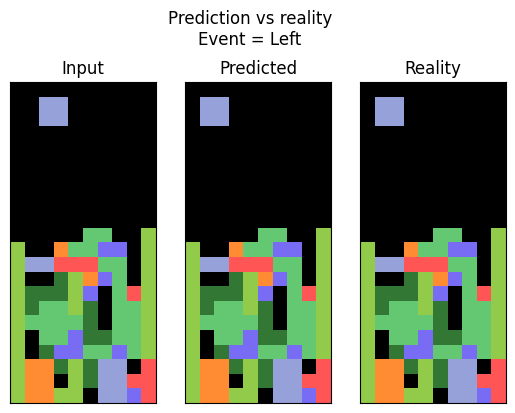

In [13]:
# Show a random training prediction vs reality
import random

idx = random.randrange(len(train_dataset))
print(f"Showing prediction for training example {idx}")
show_prediction(train_dataset[idx])

Showing prediction for test example 1750
Mistakes: 5


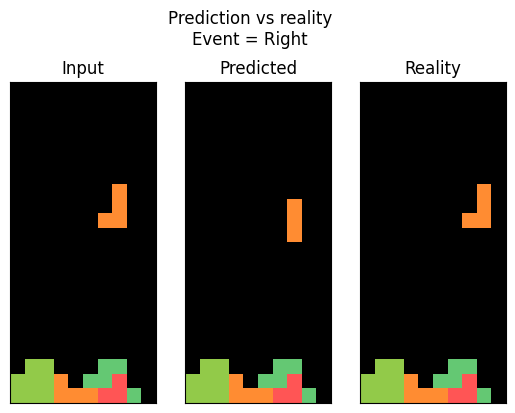

In [14]:
# Show a random test prediction vs reality
import random

idx = random.randrange(len(test_dataset))
print(f"Showing prediction for test example {idx}")
show_prediction(test_dataset[idx])

In [15]:
torch.save(gen.state_dict(), "gamegan_emulator_exp_033.pth")

# Conclusion

We changed the way events and random numbers are embedded and combined, as well as removing one layer from the `dynamics` part of the generator. The resulting board accuracies were 39% (test) and 92% (train). The cell accuracies were 98.91% (test) and 99.95% (train). The spawn recalls were 94.09% (test) and 99.69% (train).

Let's keep these architecture modifications. The next step to improve the performance will be to collect more data because according to the board accuracy, the model is severely overfitting.